In [536]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns

In [537]:
df_train = pd.read_csv('../Datathon/properties_colombia/properties_colombia_train.csv')
df_test = pd.read_csv('../Datathon/properties_colombia/properties_colombia_test.csv')

In [538]:
#Let's see what features we have
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197549 entries, 0 to 197548
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       197549 non-null  int64  
 1   id               197549 non-null  object 
 2   ad_type          197549 non-null  object 
 3   start_date       197549 non-null  object 
 4   end_date         197549 non-null  object 
 5   created_on       197549 non-null  object 
 6   lat              148051 non-null  float64
 7   lon              148051 non-null  float64
 8   l1               197549 non-null  object 
 9   l2               197549 non-null  object 
 10  l3               186517 non-null  object 
 11  l4               45367 non-null   object 
 12  l5               27409 non-null   object 
 13  l6               6867 non-null    object 
 14  rooms            27537 non-null   float64
 15  bedrooms         40525 non-null   float64
 16  bathrooms        156467 non-null  floa

In [539]:
# 'Unnamed: 0': Drop it as it doesn't mean anything 
df_train.drop('Unnamed: 0', axis=1,inplace=True)

In [540]:
# 'id': as id has no repeated values, and no correlation to the property price, we can just delete it
df_train.drop('id',axis=1,inplace=True)

In [541]:
# 'ad_type': As it only has 1 unique value, it doesn't contribute to the target feature in any way so we can get rid of it
df_train['ad_type'].head(50).unique()
df_train.drop('ad_type',axis=1,inplace=True)

In [542]:
# 'start_date': Leave it, but we shouldn't care about the date of the advert as inflation is different year by year and if
#we want to create a model that can predict the future inflation in Latin America is something out of control, so I think it's
#best if we focus on other features, for example: the amount of days the ad has been online
df_train['start_date'] = pd.to_datetime(df_train['start_date'])

In [543]:
# 'end_date': Has no use on it's own, but it can be used with start_date to see how long the ad has been online
print(df_train['end_date'].value_counts())

# Here we can see the value '9999-12-31' is repeated way more than the rest so we can analyze it as the maximum value possible in
#the ad, '2022-12-31', we could also just delete this but as it's almost 10% of our data we would leave a huge gap that would
#propagate into the 'total_days' column we will create later.

# Convert the column into datetime, if we don't raise a errors the year 9999 seen in value counts will raise an error, so we pass
#the argument 'coerce' to change it into NaT so we can make the decision later with what to do with these useless values
df_train['end_date'] = pd.to_datetime(df_train['end_date'],errors='coerce')

# I came into the conclusion that the max day was picked, and as this dataset comes from 2020-2021 we can safely assume we can 
#pick the max date from 2021 = '2021-12-31' 
df_train['end_date'].max()
df_train['end_date'] = df_train['end_date'].fillna(dt.datetime(2021,12,31))

9999-12-31    11974
2020-08-27     4059
2020-11-13     3818
2020-11-30     2871
2020-07-27     2700
              ...  
2021-08-16        2
2021-09-26        2
2021-10-03        1
2021-07-04        1
2021-06-20        1
Name: end_date, Length: 446, dtype: int64


In [544]:
# 'created_on": as there are no repeated IDs we can just get rid of 'created_on' as it's a 1 for 1 copy of 'start_date'
print(df_train.shape)
df_train[df_train['start_date'] == df_train['created_on']].shape

df_train.drop('created_on',axis=1,inplace=True)

(197549, 24)


    Latitude and Longitude ------------------------------------------------------------------------------------------

c:\Users\ivand\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


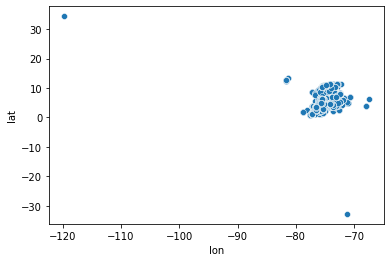

In [545]:
sns.scatterplot(df_train.lon,df_train.lat)
# We can see in the scatterplot that there are 2 outliers in our data, so let's research them
# here you can see the bottom outlier: df_train[df_train.lat == df_train.lat.min()]
# here you can see the top outlier: df_train[df_train.lat == df_train.lat.max()]
# If we insert this coordinates into a tool to find the location on the world map, we get a location in Chile and USA, 
#so it's useless in our research and we can drop it
df_train.drop(df_train.loc[df_train['lat'] == df_train.lat.min()].index,inplace=True)
df_train.drop(df_train.loc[df_train['lat'] == df_train.lat.max()].index,inplace=True)

In [546]:
# 'lat': In latitude we can use 'L2'(state) as a reference to fill up the null values 
print('Null values:',df_train.lat.isna().sum())
dict_lat = {
    'Antioquia': 7.154030,
    'Atlántico': 10.987760,
    'Cundinamarca': 4.781800,
    'Meta': 3.2720,
    'Valle del Cauca': 3.858560,
    'Caldas': 6.090000,
    'Risaralda': 4.606880,
    'Magdalena': 10.249170,
    'Santander': -0.622170,
    'Cauca': 8.252500,
    'Huila': 3.376450,
    'Bolívar': 1.833650,
    'Tolima': 4.034880,
    'Norte de Santander': 8.084580,
    'Quindío': 4.396070,
    'Caquetá': 1.113340,
    'Sucre': 8.811250,
    'Guainía': 2.719020,
    'La Guajira': 11.427780,
    'Boyacá': 5.453740,
    'Cesar': 10.769930, 
    'Amazonas': -2.056290,
    'San Andrés Providencia y Santa Catalina': 12.542720,
    'Casanare': 5.296580,
    'Vichada': 4.712170,
    'Córdoba': 9.586680,
    'Chocó': 6.320330
}

df_train['lat'] = df_train.lat.fillna(df_train.l2.map(dict_lat))
print('Null values:',df_train.lat.isna().sum())

Null values: 49498
Null values: 0


In [547]:
# 'lon': In longitude we can use 'L2'(state) as a reference to fill up the null values 
print('Null values:',df_train.lon.isna().sum())
dict_lon = {
    'Antioquia': -75.503349,
    'Atlántico': -74.954620,
    'Cundinamarca': -73.970757,
    'Meta': -73.0877,
    'Valle del Cauca': -76.519810,
    'Caldas': -75.636627,
    'Risaralda': -74.071840,
    'Magdalena': -74.261080,
    'Santander': -72.382812,
    'Cauca': -74.722893,
    'Huila': -74.802391,
    'Bolívar': -76.967293,
    'Tolima': -75.255890,
    'Norte de Santander': -72.842781,
    'Quindío': -75.640083,
    'Caquetá': -73.813004,
    'Sucre': -74.721390,
    'Guainía': -67.566940, 
    'La Guajira': -72.388634,
    'Boyacá': -73.362480,
    'Cesar': -73.004791, 
    'Amazonas': -71.892921,
    'San Andrés Providencia y Santa Catalina': -81.717900,
    'Casanare': -71.456268,
    'Vichada': -69.414350,
    'Córdoba': -74.826302,
    'Chocó': -76.944901
}

df_train['lon'] = df_train.lon.fillna(df_train.l2.map(dict_lon))
print('Null values:',df_train.lon.isna().sum())

Null values: 49498
Null values: 0


c:\Users\ivand\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lon', ylabel='lat'>

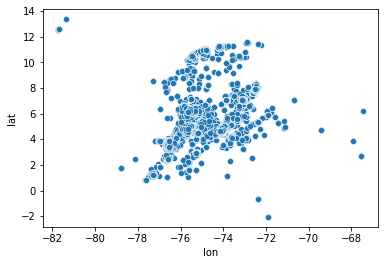

In [566]:
# Now the scatterplot is in a much closer range and not outliers are seen
sns.scatterplot(df_train.lon,df_train.lat)

    ------------------------------------------------------------------------------------------------------------------

In [567]:
# 'l1': Having information on what country we're situated in is useless as this dataset is situated in Colombia already
print(df_train.l1.unique())
df_train.drop('l1',axis=1,inplace=True)

['Colombia']


In [586]:
# 'l2': Here I check that it has all the states in Colombia.
Departamentos_colombianos = ['Amazonas','Antioquia','Arauca','Atlántico','Bolívar','Boyacá','Caldas','Caquetá',
'Casanare','Cauca','Cesar','Chocó','Córdoba','Cundinamarca','Guainía','Guaviare','Huila','La Guajira','Magdalena',
'Meta','Nariño','Norte de Santander','Putumayo','Quindí','Risarald','San Andrés y Providencia','Santander','Sucre','Tolima',
'Valle del Cauca','Vaupé','Vichada']

result = any(e in list(df_train.l2.unique()) for e in Departamentos_colombianos )

result 

True

In [588]:
# 'l3': Here there really isn't a way to check if all these cities are Colombian as we're going into way less defined territory
#so what I do is just look at all the unique values by eye as it's not big enough yet, to see if there is a wrongly inputted name
df_train.l3.unique()

array(['Medellín', 'Bogotá D.C', 'Bucaramanga', 'Manizales',
       'Barranquilla', 'Cali', nan, 'Montería', 'Palmira', 'Popayán',
       'Simijaca', 'Piedecuesta', 'Villavicencio', 'Soacha', 'Cúcuta',
       'Cartago', 'Jamundí', 'Pereira', 'Puerto López', 'Zipaquirá',
       'Cogua', 'Rionegro', 'Vijes', 'Cartagena', 'Santa Marta', 'Ibagué',
       'Floridablanca', 'Bello', 'Armenia', 'Silvania', 'Tocancipá',
       'Chía', 'Barbosa', 'Palestina', 'La Ceja', 'Sabaneta', 'Envigado',
       'Dagua', 'Neiva', 'Cota', 'Guarne', 'San Francisco', 'Tocaima',
       'Cajicá', 'Tuluá', 'Barrancabermeja', 'Marinilla', 'Girardot',
       'Tunja', 'Funza', 'La Cumbre', 'Durania', 'Itagui', 'Soledad',
       'Melgar', 'Saldaña', 'La Estrella', 'Fusagasugá', 'Nemocón',
       'Malambo', 'Tabio', 'Paipa', 'Mosquera', 'Caldas', 'Arbeláez',
       'La Calera', 'Girón', 'Flandes', 'Guatapé', 'Sesquilé',
       'Sabanalarga', 'Turbo', 'Subachoque', 'Yopal', 'Carmen de Apicalá',
       'Sibaté', 'Copaca

In [601]:
# 'l4': The amount of neighbourhoods is not even close to the real one, AND we have high amount of nulls
print('Nulls:',df_train[df_train.l4.isna()].shape[0])
print('Unique values:', df_train.l4.nunique())

Nulls: 152180
Unique values: 58


In [602]:
# 'l5': same as 'l4'
print('Nulls:',df_train[df_train.l5.isna()].shape[0])
print('Unique values:', df_train.l5.nunique())

Nulls: 170138
Unique values: 20


In [603]:
# 'l6': same as 'l4'
print('Nulls:',df_train[df_train.l6.isna()].shape[0])
print('Unique values:', df_train.l6.nunique())

Nulls: 190680
Unique values: 146


    Property Rooms ---------------------

In [610]:
# 'rooms':
print('Nulls:',df_train[df_train.rooms.isna()].shape[0])

Nulls: 170012


In [612]:
# 'bedrooms':
print('Nulls:',df_train[df_train.bedrooms.isna()].shape[0])

Nulls: 157022


In [ ]:
# 'bathrooms':

    ------------------------------------------------------------------------------------------------------------------

In [556]:
# 'surface_total':

In [557]:
# 'surface_covered':

In [558]:
# 'price':

In [559]:
# 'currency':

In [560]:
# 'price_period':


In [561]:
# 'title':
df_train['title']

0         Hermosa Mansión En El Poblado. Área Construida...
1          APARTAMENTO EN VENTA, BOGOTA-CIUDAD JARDIN NORTE
2         Apartamento En Venta En Bogota Bella Suiza Cod...
3         SE VENDE LOCAL COMERCIAL EN CABECERA DEL LLANO...
4                    Apartamento en Venta Ubicado en ITAGUI
                                ...                        
197544           LM: VENDO APARTAMENTO EN TORRES DE TINTALA
197545    Oficina En Venta En Bogota El Retiro Cod. VREI...
197546    Local En Venta En Cali Nueva Tequendama CodVBS...
197547                              VENTA CASALOTE FONTIBON
197548    1 Apartamento en remate aprovecha nuestras ofe...
Name: title, Length: 197547, dtype: object

In [562]:
# 'description':
df_train['description'][0]

"<b>Hermosa Mansión En El Poblado. Área Construida. 900m2.</b><br><br>Hermosa Mansi&oacute;n En El Poblado.<br />\n<br />\n2 Niveles y s&oacute;tano:<br />\n<br />\n1er Niver<br />\nSal&oacute;n<br />\nComedor <br />\nCocina abierta con isla<br />\nDeck abierto con piscina infinita con vista a la ciudad<br />\nJacuzzi<br />\nZona BBQ<br />\nGimnasio<br />\nZona de ropas<br />\nAlacena<br />\nParqueadero cubierto para 6 carros<br />\nCuarto &Uacute;til externo<br />\n<br />\n2do Nivel<br />\n<br />\n3 Habitaciones con ba&ntilde;o y vestier<br />\nJacuzzi<br />\nBalc&oacute;n <br />\nSala de cine<br />\nBiblioteca<br />\n<br />\nTiene adicional cancha de microfutbol en grama natura<br />\nTiene cine privado dentro de la mansi&oacute;n<br />\n<br />\nSotano: <br />\nEspacio multiple para juegos de mesa <br />\nHabitaciones adicionales<br />\nBa&ntilde;o<br />\nInstalaciones de acueducto <br />\nEnerg&iacute;a suficiente<br />\n<br />\nSus alrededores est&aacute;n dotadas de un bonito jard

In [563]:
# 'property_type':

In [564]:
# 'operation_type':

In [565]:
# 'geometry':